# Time mean plts

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
sose_wmt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/models/SOSE/wmt_budget_terms.zarr'), consolidated=False)
#omega_surf = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/models/SOSE/omega_surf.zarr'), consolidated=False)
#get rid of old surf terms and add corrected surf terms to wmt ds
#sose_uncut = xr.merge([sose_wmt.drop(['omega_surf', 'omega_surf_slt', 'omega_surf_th']), omega_surf])
sose = sose_wmt.sel(time=slice('2006', '2010')).load()

ecco = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/wmt_budget_terms.zarr'), consolidated=False).load()

In [4]:
soda_unsliced = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/wmt_budget_terms.zarr'), consolidated=False)

In [7]:
#Converting time from Julian to datetime64[ns] object
datetimeindex = soda_unsliced.indexes['time'].to_datetimeindex()
soda_unsliced['time'] = datetimeindex
soda = soda_unsliced#.sel(time=slice('1997-02-15', '2019'))
soda.load()

/tmp/ipykernel_1750/3806529637.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = soda_unsliced.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float64 -0.6901 -0.6901 ... 0.0 0.0
    u_binned_left   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned_lower  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned_upper  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

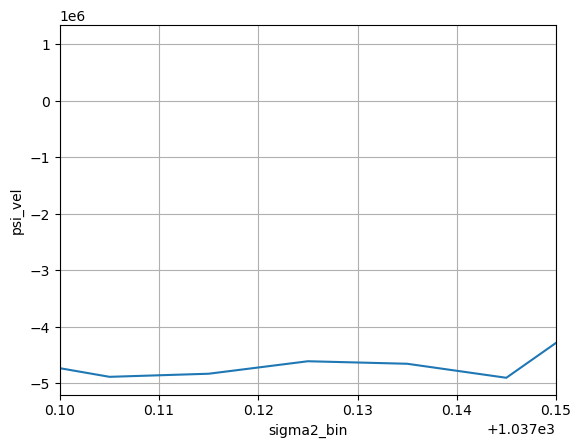

In [18]:
sose.psi_vel.mean('time').plot()
plt.xlim(1037.1, 1037.15)
plt.grid()

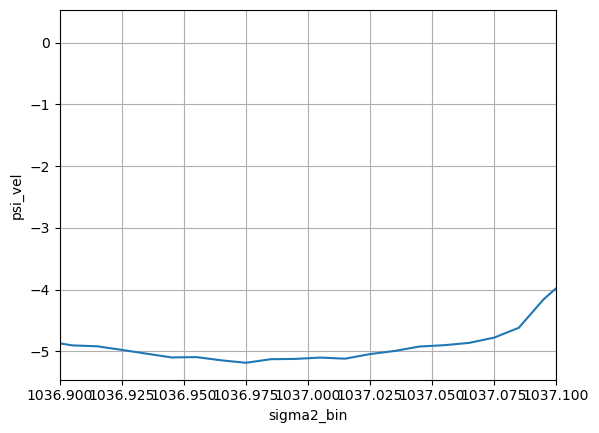

In [72]:
soda.psi_vel.mean('time').plot()
#plt.xlim(1036.95, 1037)
plt.xlim(1036.9, 1037.1)
plt.grid()

In [67]:
1036.95+.07

1037.02

In [41]:
soda.psi_vel.mean('time').min() #-5.18626761

<xarray.DataArray 'psi_vel' ()>
array(-5.18626761)

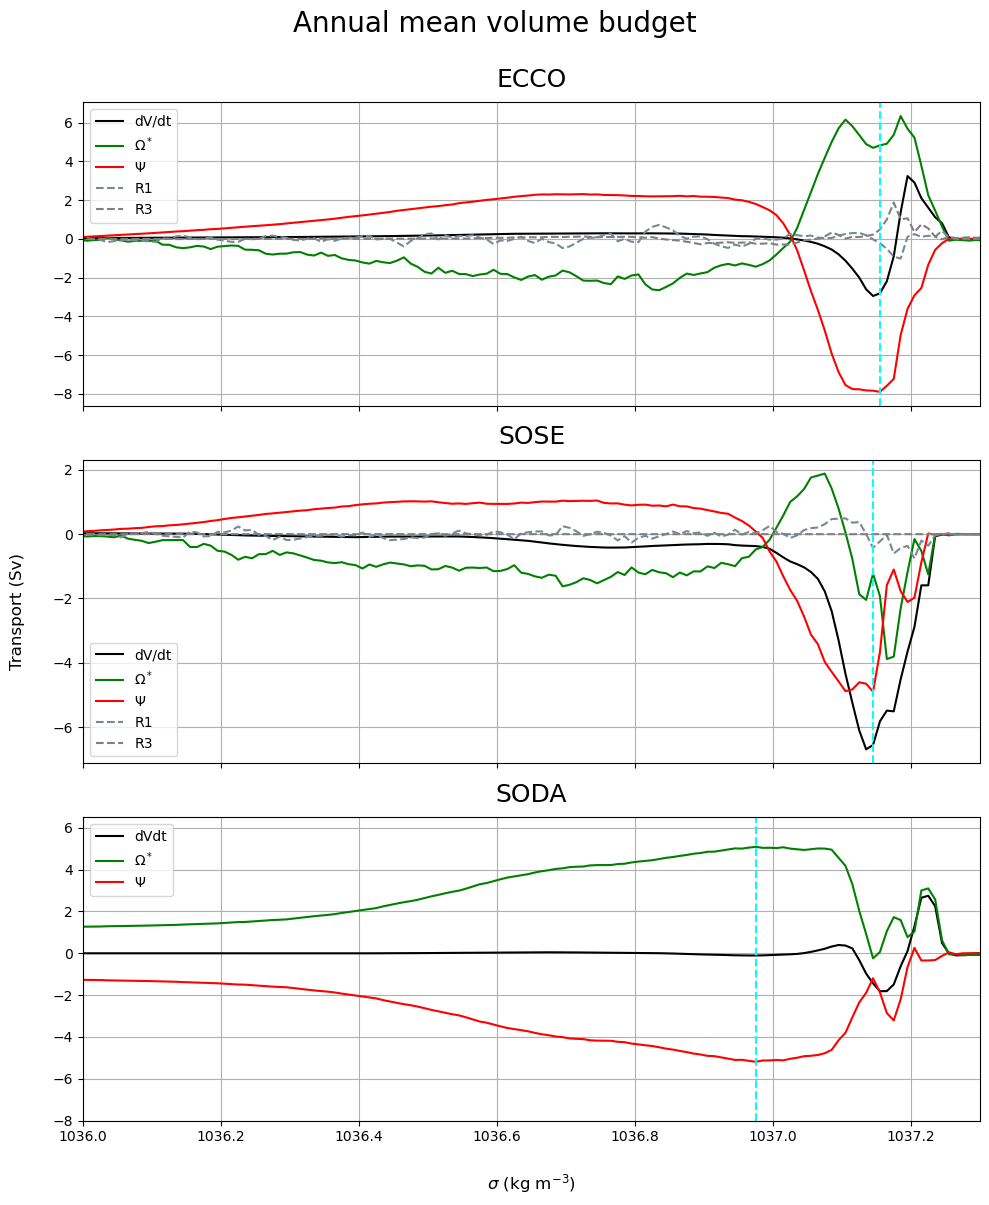

In [74]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(10,12), sharex=True)

(ecco.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
((ecco.omega_trans_rate+ecco.R2)/1e6).mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax0)
(ecco.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax0)
#(ecco.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax0)
(ecco.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--', ax=ax0)
(ecco.R3/1e6).mean(dim='time').plot(label='R3', color='grey', linestyle='--', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.legend()
ax0.grid()
ax0.set_title('ECCO', fontsize=18, pad=11)
ax0.set_xlim(1036, 1037.3)
ax0.axvline(x = 1037.155, color = 'cyan', linestyle='dashed')

(sose.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
((sose.omega_trans_rate+sose.R2)/1e6).mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax1)
(sose.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax1)
#(sose.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax1)
(sose.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--', ax=ax1)
(sose.R3/1e6).mean(dim='time').plot(label='R3', color='grey', linestyle='--', ax=ax1)
ax1.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax1.legend()
ax1.grid()
ax1.set_xlabel('')
ax1.set_title('SOSE', fontsize=18, pad=11)
ax1.set_xlim(1036, 1037.3)
ax1.axvline(x = 1037.145, color = 'cyan', linestyle='dashed')

(soda.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k', ax=ax2)
soda.omega_trans.mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax2)
soda.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax2)
ax2.grid()
ax2.legend()
ax2.set_xlabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=12, labelpad=20)
ax2.set_ylabel('')
ax2.set_ylim(-8,6.5)
ax2.set_xlim(1036, 1037.3)
ax2.set_title('SODA', fontsize=18, pad=11)
ax2.axvline(x = 1036.975, color = 'cyan', linestyle='dashed')

plt.suptitle('Annual mean volume budget', fontsize=20, y=1)
plt.tight_layout()
plt.savefig('time-mean-stacked.pdf', transparent=True);

## $\Omega$'s components

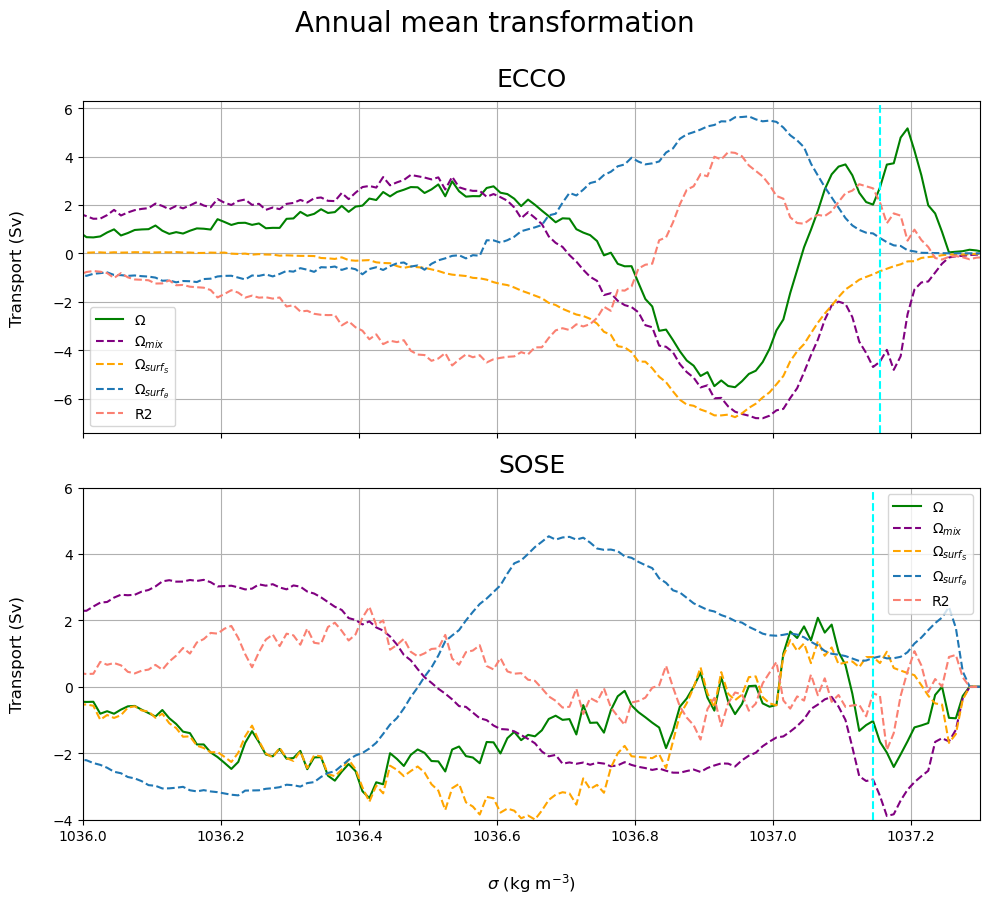

In [81]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,9), sharex=True)

(ecco.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', ax=ax0)
(ecco.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed', ax=ax0)
(ecco.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed', ax=ax0)
(ecco.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed', ax=ax0)
(ecco.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax0.legend()
ax0.grid()
ax0.set_title('ECCO', fontsize=18, pad=11)
ax0.set_xlim(1036, 1037.3)
ax0.axvline(x = 1037.155, color = 'cyan', linestyle='dashed')

(sose.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(sose.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(sose.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(sose.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(sose.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
ax1.grid()
ax1.legend()
ax1.set_xlabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=12, labelpad=20)
ax1.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax1.set_ylim(-4,6)
ax1.set_xlim(1036, 1037.3)
ax1.set_title('SOSE', fontsize=18, pad=11)
ax1.axvline(x = 1037.145, color = 'cyan', linestyle='dashed');


plt.suptitle('Annual mean transformation', fontsize=20, y=1)
plt.tight_layout()
plt.savefig('time-mean-omegas-stacked.pdf', transparent=True);

## Bar view

In [82]:
bot_ecco = - (ecco.mean('time').isel(sigma2_bin=-1) - 
              ecco.mean('time').sel(sigma2_bin=1037.155, method='nearest'))
bot_sose = - (sose.mean('time').isel(sigma2_bin=-1) - 
              sose.mean('time').sel(sigma2_bin=1037.145, method='nearest'))
bot_soda = - (soda.mean('time').isel(sigma2_bin=-1) - 
              soda.mean('time').sel(sigma2_bin=1036.975, method='nearest'))

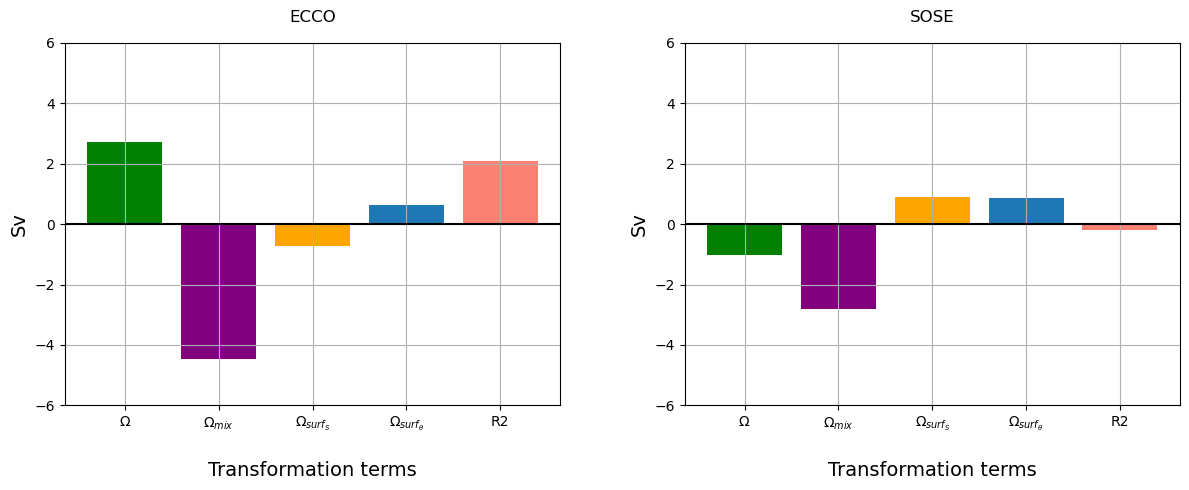

In [84]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\Omega$', height = bot_ecco.omega_trans_rate/1e6, color='green')
ax0.bar(x=r'$\Omega_{mix}$', height = bot_ecco.omega_mix/1e6, color='purple')
ax0.bar(x=r'$\Omega_{surf_S}$', height= bot_ecco.omega_surf_slt/1e6, color='orange')
ax0.bar(x=r'$\Omega_{surf_\theta}$', height= bot_ecco.omega_surf_th/1e6, color='C0')
ax0.bar(x='R2', height=bot_ecco.R2/1e6, color='salmon')
ax0.axhline(y=0, color='k')
ax0.set_title('ECCO', pad=15)
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('Transformation terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-6,6)

ax1.bar(x=r'$\Omega$', height = bot_sose.omega_trans_rate/1e6, color='green')
ax1.bar(x=r'$\Omega_{mix}$', height = bot_sose.omega_mix/1e6, color='purple')
ax1.bar(x=r'$\Omega_{surf_S}$', height= bot_sose.omega_surf_slt/1e6, color='orange')
ax1.bar(x=r'$\Omega_{surf_\theta}$', height= bot_sose.omega_surf_th/1e6, color='C0')
ax1.bar(x='R2', height=bot_sose.R2/1e6, color='salmon')
ax1.axhline(y=0, color='k')
ax1.set_title('SOSE', pad=15)
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('Transformation terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-6,6)

plt.tight_layout(w_pad=5);